In [1]:
import os
import json
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pandas_datareader as web
from dateutil.relativedelta import relativedelta
import h5py
from dotenv import load_dotenv
import yaml
from ticker_download_predict_upload import DownloadPredictUpload
from s3_uploader import S3Uploader

In [2]:
dpu = DownloadPredictUpload()

### Set the tickers in the portfolio

In [3]:
tickers = ["I:SPX", "QQQ", "VXUS", "GLD"]
D = len(tickers)

### Get the past year of ticker close prices

In [4]:
long_df_filename = os.path.join("input", f"Year of Tickers {dpu.get_today_date()}.csv")
if os.path.exists(long_df_filename):
    long_df = pd.read_csv(long_df_filename)
    long_df["datetime"] = pd.to_datetime(long_df["datetime"])
    long_df["datetime"] = long_df["datetime"].apply(
        lambda x: pd.Timestamp(x).replace(hour=23, minute=59, second=59)
    )
    long_df.set_index("datetime", inplace=True)
    long_df.sort_index(inplace=True)
else:
    date_from = dpu.past_business_day(pd.Timestamp(dpu.get_today_date()), 253)
    date_to = dpu.past_business_day(pd.Timestamp(dpu.get_today_date()), 1).replace(
        hour=23, minute=59, second=59
    )
    print(date_from, date_to)
    long_df = dpu.get_tickers(tickers, date_from=date_from, date_to=date_to)
    long_df.to_csv(long_df_filename, index=True)
long_df

,ticker,open,high,low,close,volume,vwap,transactions
datetime,,,,,,,,
2024-03-27 23:59:59,I:SPX,5226.31,5249.260,5213.920,5248.49,NaN,NaN,NaN
2024-03-27 23:59:59,QQQ,446.44,446.540,441.930,444.83,41192040.0,443.6579,362645.0
2024-03-27 23:59:59,GLD,202.32,203.220,202.320,203.10,6026980.0,202.8967,59141.0
2024-03-27 23:59:59,VXUS,60.08,60.325,60.020,60.32,2444274.0,60.1544,14281.0
2024-03-28 23:59:59,GLD,204.54,206.050,203.870,205.72,9194473.0,205.2483,85976.0
...,...,...,...,...,...,...,...,...
2025-03-31 23:59:59,I:SPX,5527.91,5627.560,5488.730,5611.85,NaN,NaN,NaN
2025-04-01 23:59:59,QQQ,467.30,473.630,464.420,472.70,41146658.0,469.8705,492825.0
2025-04-01 23:59:59,I:SPX,5597.53,5650.570,5558.520,5633.07,NaN,NaN,NaN


### Pivot the close prices for better analysis

In [5]:
wide_df = dpu.pivot_ticker_close_wide(long_df)
date_from = wide_df.index[0]
date_to = wide_df.index[-1]
wide_df

ticker,GLD,I:SPX,QQQ,VXUS
2024-03-27 17:00:00,203.10,5248.49,444.83,60.32
2024-03-28 17:00:00,205.72,5254.35,444.01,60.30
2024-04-01 17:00:00,207.82,5243.77,444.95,60.19
2024-04-02 17:00:00,210.89,5205.81,441.11,59.94
2024-04-03 17:00:00,212.74,5211.49,442.10,60.20
...,...,...,...,...
2025-03-26 17:00:00,278.24,5712.20,484.38,63.11
2025-03-27 17:00:00,281.97,5693.31,481.62,63.25
2025-03-28 17:00:00,284.06,5580.94,468.94,62.51
2025-03-31 17:00:00,288.14,5611.85,468.92,62.10


### Are there any missing values?

In [6]:
wide_df.isna().sum().sum()

np.int64(0)

### Calculate % change and covert to a percentage

In [7]:
returns_df = wide_df.pct_change()
returns_df = returns_df.iloc[1:] * 100
returns_df

ticker,GLD,I:SPX,QQQ,VXUS
2024-03-28 17:00:00,1.290005,0.111651,-0.184340,-0.033156
2024-04-01 17:00:00,1.020805,-0.201357,0.211707,-0.182421
2024-04-02 17:00:00,1.477240,-0.723907,-0.863018,-0.415351
2024-04-03 17:00:00,0.877235,0.109109,0.224434,0.433767
2024-04-04 17:00:00,-0.573470,-1.233428,-1.529066,-0.681063
...,...,...,...,...
2025-03-26 17:00:00,-0.082594,-1.115699,-1.840068,-1.034969
2025-03-27 17:00:00,1.340569,-0.330696,-0.569801,0.221835
2025-03-28 17:00:00,0.741214,-1.973720,-2.632781,-1.169960
2025-03-31 17:00:00,1.436316,0.553849,-0.004265,-0.655895


### Calculate mean returns

In [8]:
mean_returns = returns_df.mean()
mean_returns

ticker
GLD      0.142316
I:SPX    0.031804
QQQ      0.031627
VXUS     0.016243
dtype: float64

### Calculate covariance matrix

In [9]:
cov = returns_df.cov()
cov_np = cov.to_numpy()
cov

ticker,GLD,I:SPX,QQQ,VXUS
ticker,,,,
GLD,0.954305,0.174025,0.250285,0.337045
I:SPX,0.174025,0.770904,1.028598,0.501299
QQQ,0.250285,1.028598,1.520345,0.663570
VXUS,0.337045,0.501299,0.663570,0.722873


### Simulate 10,000 portfolios by generating random weights

In [10]:
def softmax_random_distribution(D):
    """
    Generates a NumPy array of D random floats that sum to 1.0 using the softmax function.

    The process involves:
    1. Generating D random numbers (from a standard normal distribution).
    2. Applying the softmax function to these numbers. Softmax converts a vector
        of numbers into a probability distribution where each element is non-negative
        and all elements sum to 1.0.

    Args:
    D (int): The desired number of elements (dimension) in the output array.
                Must be a positive integer.

    Returns:
    np.ndarray: A NumPy array of shape (D,) containing floats that sum to 1.0.

    Raises:
    ValueError: If D is not a positive integer.
    """
    if not isinstance(D, int) or D <= 0:
        raise ValueError("Dimension D must be a positive integer.")

    # 1. Generate D random numbers (e.g., from standard normal distribution)
    # Using np.random.randn provides values centered around 0.
    # Using np.random.rand would provide values between 0 and 1. Either works.
    random_inputs = np.random.randn(D)

    # 2. Apply the softmax function
    # Subtracting the max value before exponentiating is crucial for
    # numerical stability, preventing potential overflow if inputs are large.
    # exp(x - max(x)) / sum(exp(x - max(x))) == exp(x) / sum(exp(x))
    stable_inputs = random_inputs - np.max(random_inputs)
    exponentials = np.exp(stable_inputs)
    softmax_output = exponentials / np.sum(exponentials)

    # The sum will be extremely close to 1.0 due to floating point precision.
    # For most practical purposes, this is sufficient.
    # If absolute exactness to 1.0 is needed despite floating point limits,
    # one might normalize slightly differently, but softmax naturally targets 1.0.

    return softmax_output

In [11]:
n_portfolios = 10_000
simulated_returns = np.zeros(n_portfolios)
simulated_risks = np.zeros(n_portfolios)
random_weights = []
rand_range = 1.0

for i in range(n_portfolios):
    # w = np.random.random(D) * rand_range - rand_range / 2  # Allows short selling
    # w = np.random.random(D) * rand_range  # No short selling
    # w[-1] = 1 - w[:-1].sum()
    # np.random.shuffle(w)
    w = softmax_random_distribution(D)
    print(w)
    random_weights.append(w)
    simulated_return = mean_returns.dot(w)
    simulated_risk = np.sqrt(w.dot(cov_np).dot(w))
    simulated_returns[i] = simulated_return
    simulated_risks[i] = simulated_risk

[0.56625319 0.32349116 0.07401807 0.03623758]
[0.55869889 0.16420975 0.12900243 0.14808893]
[0.86248013 0.02941215 0.02347037 0.08463735]
[0.01293866 0.44668262 0.47150109 0.06887763]
[0.08901613 0.05540723 0.71200897 0.14356767]
[0.41079891 0.19580392 0.09563082 0.29776636]
[0.45757232 0.14725693 0.33987557 0.05529518]
[0.42704693 0.3550784  0.18617138 0.03170329]
[0.12887981 0.06233286 0.03600485 0.77278248]
[0.23554681 0.41296909 0.10310086 0.24838324]
[0.25972368 0.66174021 0.04932014 0.02921597]
[0.248186   0.16669315 0.43041349 0.15470735]
[0.67182066 0.23650212 0.05789184 0.03378538]
[0.1093278  0.02031375 0.03260875 0.8377497 ]
[0.11078558 0.03622743 0.01797395 0.83501304]
[0.55477829 0.13240729 0.14624862 0.1665658 ]
[0.0521056  0.71737194 0.06029414 0.17022831]
[0.452332   0.33813235 0.0707974  0.13873825]
[0.11008127 0.36820577 0.40124958 0.12046338]
[0.05696936 0.68115662 0.11782838 0.14404564]
[0.15180804 0.21761296 0.23021283 0.40036617]
[0.18819734 0.13123726 0.12582026 

### Calculate minimum variance portfolio

In [12]:
# weight_bounds = [(-0.5, None)] * D  # Allows shorting
weight_bounds = [(0.0, 1.0) for _ in range(D)]  # No shorting

In [13]:
def get_portfolio_variance(weights):
    return weights.dot(cov_np).dot(weights)

In [14]:
def portfolio_weights_constraint(weights):
    return weights.sum() - 1

In [15]:
min_var_result = minimize(
    fun=get_portfolio_variance,
    x0=np.ones(D) / D,
    method="SLSQP",
    bounds=weight_bounds,
    constraints={"type": "eq", "fun": portfolio_weights_constraint},
)
min_var_result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.49323637596963266
       x: [ 3.607e-01  4.083e-01  0.000e+00  2.310e-01]
     nit: 7
     jac: [ 9.863e-01  9.866e-01  1.327e+00  9.865e-01]
    nfev: 35
    njev: 7

In [16]:
min_var_risk = np.sqrt(min_var_result.fun)
min_var_weights = min_var_result.x
min_var_return = min_var_weights.dot(mean_returns)
min_var_risk, min_var_weights, min_var_return

(np.float64(0.7023078925725046),
 array([0.36072018, 0.40825694, 0.        , 0.23102288]),
 np.float64(0.068073215273834))

### Calculate efficient frontier

In [17]:
num_portfolios = 100
min_simulated_return = min(simulated_returns)
max_simualted_return = max(simulated_returns)
print(f"Possible returns range: {min_simulated_return:.4f} to {max_simualted_return:.4f}")
target_returns = np.linspace(min_simulated_return, max_simualted_return, num_portfolios)
target_returns

Possible returns range: 0.0180 to 0.1374


array([0.01796086, 0.01916755, 0.02037424, 0.02158093, 0.02278761,
       0.0239943 , 0.02520099, 0.02640768, 0.02761437, 0.02882106,
       0.03002775, 0.03123444, 0.03244113, 0.03364781, 0.0348545 ,
       0.03606119, 0.03726788, 0.03847457, 0.03968126, 0.04088795,
       0.04209464, 0.04330133, 0.04450801, 0.0457147 , 0.04692139,
       0.04812808, 0.04933477, 0.05054146, 0.05174815, 0.05295484,
       0.05416153, 0.05536821, 0.0565749 , 0.05778159, 0.05898828,
       0.06019497, 0.06140166, 0.06260835, 0.06381504, 0.06502173,
       0.06622841, 0.0674351 , 0.06864179, 0.06984848, 0.07105517,
       0.07226186, 0.07346855, 0.07467524, 0.07588193, 0.07708861,
       0.0782953 , 0.07950199, 0.08070868, 0.08191537, 0.08312206,
       0.08432875, 0.08553544, 0.08674213, 0.08794881, 0.0891555 ,
       0.09036219, 0.09156888, 0.09277557, 0.09398226, 0.09518895,
       0.09639564, 0.09760233, 0.09880901, 0.1000157 , 0.10122239,
       0.10242908, 0.10363577, 0.10484246, 0.10604915, 0.10725

In [18]:
def target_returns_constraint(weights, target_return):
    return weights.dot(mean_returns) - target_return

In [19]:
constraints = [
    {"type": "eq", "fun": target_returns_constraint, "args": [target_returns[0]]},
    {"type": "eq", "fun": portfolio_weights_constraint},
]

In [20]:
# optimized_risks = []
# for target_return in target_returns:
#     constraints[0]["args"] = [target_return]
#     result = minimize(
#         fun=get_portfolio_variance,
#         x0=np.ones(D) / D,
#         method="SLSQP",
#         bounds=weight_bounds,
#         constraints=constraints,
#     )
#     if result.status == 0:
#         optimized_risks.append(np.sqrt(result.fun))
#     else:
#         print("Optimization error!", result)

print("Weight bounds", weight_bounds)

optimized_risks = []
for target_return in target_returns:
    constraints[0]["args"] = [target_return]
    result = minimize(
        fun=get_portfolio_variance,
        x0=np.ones(D) / D,
        method="SLSQP",
        bounds=weight_bounds,
        constraints=constraints,
    )
    if result.status == 0:
        optimized_risks.append(np.sqrt(result.fun))
    else:
        optimized_risks.append(np.nan)
        print(f"Infeasible target return: {target_return:.4f}")

Weight bounds [(0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0)]


### Calculate Sharpe Ratio

In [21]:
today_date = dpu.get_today_date()
risk_free_rate_filename = os.path.join("input", f"Risk Free Rate {today_date}.json")
if os.path.exists(risk_free_rate_filename):
    print("Reading risk-free rate cache...")
    with open(risk_free_rate_filename, "r", encoding="utf-8") as f:
        risk_free_rate_data = json.load(f)
        print(risk_free_rate_data)
        daily_risk_free_rate = risk_free_rate_data["daily_risk_free_rate"]
else:
    end_date = datetime.datetime.now()
    start_date = end_date - relativedelta(years=1)
    print(start_date, end_date)
    tb3m_df = web.DataReader("DTB3", "fred", start_date, end_date).sort_values(
        "DATE", ascending=False
    )
    risk_free_rate = float(tb3m_df.iloc[0]["DTB3"])
    daily_risk_free_rate = risk_free_rate / 252
    risk_free_rate_date = str(tb3m_df.index[0])
    print(daily_risk_free_rate)
    risk_free_rate_data = {
        "risk_free_rate": risk_free_rate,
        "daily_risk_free_rate": daily_risk_free_rate,
        "risk_free_rate_date": risk_free_rate_date,
    }
    with open(risk_free_rate_filename, "w", encoding="utf-8") as f:
        json.dump(risk_free_rate_data, f, indent=4)

Reading risk-free rate cache...
{'risk_free_rate': 4.21, 'daily_risk_free_rate': 0.016706349206349207, 'risk_free_rate_date': '2025-03-31 00:00:00'}


In [22]:
def negative_sharpe_ratio(weights):
    mean = weights.dot(mean_returns)
    risk = np.sqrt(weights.dot(cov_np).dot(weights))
    return -(mean - daily_risk_free_rate) / risk

In [23]:
sharpe_ratio_result = minimize(
    fun=negative_sharpe_ratio,
    x0=np.ones(D) / D,
    method="SLSQP",
    bounds=weight_bounds,
    constraints={"type": "eq", "fun": portfolio_weights_constraint},
)
sharpe_ratio_result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.12858225973340937
       x: [ 1.000e+00  0.000e+00  3.469e-18  7.922e-18]
     nit: 5
     jac: [-1.710e-02 -9.109e-03  1.348e-03  2.879e-02]
    nfev: 25
    njev: 5

In [24]:
best_sharpe_ratio = -sharpe_ratio_result.fun
best_weights = sharpe_ratio_result.x
opt_risk = np.sqrt(best_weights.dot(cov_np).dot(best_weights))
opt_return = best_weights.dot(mean_returns)
best_sharpe_ratio, best_weights

(np.float64(0.12858225973340937),
 array([1.00000000e+00, 0.00000000e+00, 3.46944695e-18, 7.92193527e-18]))

### Calculate tangency line

In [25]:
tangency_max_risk = max(optimized_risks)
tangency_xs = np.linspace(0, tangency_max_risk, 100)
tangency_ys = daily_risk_free_rate + best_sharpe_ratio * tangency_xs

### FINALLY! Put it all on a plot

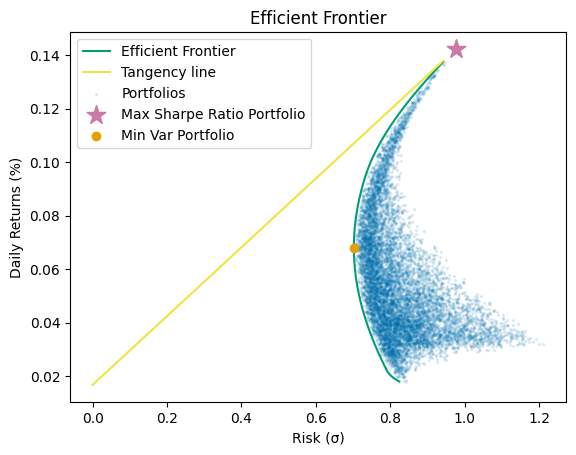

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(
    optimized_risks, target_returns, c="#009E73", zorder=1, label="Efficient Frontier"
)
ax.plot(tangency_xs, tangency_ys, c="#F0E442", zorder=1, label="Tangency line")
ax.scatter(
    simulated_risks,
    simulated_returns,
    alpha=0.1,
    s=2,
    c="#0072B2",
    zorder=10,
    label="Portfolios",
)
ax.scatter(
    [opt_risk],
    [opt_return],
    c="#CC79A7",
    marker="*",
    s=200,
    zorder=10,
    label="Max Sharpe Ratio Portfolio",
)
ax.scatter(
    [min_var_risk], [min_var_return], c="#E69F00", zorder=10, label="Min Var Portfolio"
)
ax.set_xlabel("Risk (σ)")
ax.set_ylabel("Daily Returns (%)")
ax.set_title("Efficient Frontier")
ax.legend()

### Annualize optimum return.

In [31]:
annualized_optimum_return = ((1 + opt_return / 100) ** 252 - 1) * 100
annualized_optimum_risk = opt_risk * np.sqrt(252)
print(annualized_optimum_return, annualized_optimum_risk)

43.101288576662114 15.507571548569672


### Write an HDF5 file with everything needed to regenerate plot

In [28]:
portfolio_optimization_plot_data_filename = os.path.join(
    "output", "portfolio_optimization_plot_data.h5"
)
with h5py.File(portfolio_optimization_plot_data_filename, "w") as hf:
    efficient_frontier_group = hf.create_group("efficient_frontier")
    tangency_line_group = hf.create_group("tangency_line")
    simulated_portfolios_group = hf.create_group("simulated_portfolios")
    max_sharpe_ratio_group = hf.create_group("max_sharpe_ratio")
    min_var_portfolio_group = hf.create_group("min_var_portfolio")
    efficient_frontier_group.create_dataset("xs", data=optimized_risks)
    efficient_frontier_group.create_dataset("ys", data=target_returns)
    tangency_line_group.create_dataset("xs", data=tangency_xs)
    tangency_line_group.create_dataset("ys", data=tangency_ys)
    simulated_portfolios_group.create_dataset("xs", data=simulated_risks)
    simulated_portfolios_group.create_dataset("ys", data=simulated_returns)
    max_sharpe_ratio_group.create_dataset("xs", data=[opt_risk])
    max_sharpe_ratio_group.create_dataset("ys", data=[opt_return])
    min_var_portfolio_group.create_dataset("xs", data=[min_var_risk])
    min_var_portfolio_group.create_dataset("ys", data=[min_var_return])
print(f"Saved {portfolio_optimization_plot_data_filename}")

Saved output/portfolio_optimization_plot_data.h5


In [29]:
load_dotenv()
s3u = S3Uploader()

# space_name = os.getenv("PORTFOLIO_OPTIMIZATION_SPACE_NAME")
# s3u.upload_file(
#     portfolio_optimization_plot_data_filename,
#     space_name,
#     "portfolio_optimization_plot_data.h5",
# )

### Upload metadata about the plot for the front end UI

In [30]:
metadata = {
    "date_updated": {
        "date_from": str(date_from.date()),
        "date_to": str(date_to.date()),
    },
    "tickers": tickers,
    "risk_free_rate": risk_free_rate_data,
    "optimum_portfolio": {
        "annualized_return": float(annualized_optimum_return),
        "risk": float(annualized_optimum_risk),
    }
}

metadata_filename = os.path.join("output", "optimization_metadata.yml")
with open(metadata_filename, "w") as f:
    yaml.dump(metadata, f, default_flow_style=False)

# s3u.upload_file(
#     metadata_filename,
#     space_name,
#     "optimization_metadata.yml",
# )